# Recherche des features importantes

## Chargement des librairies

In [1]:
# import custom module
import sys
sys.path.insert(0, "../custom_functions")
from model_analysis import plot_confusion_matrix

In [2]:
# import standard ML librairies
import pandas as pd
import numpy as np
from collections import Counter
import  matplotlib.pyplot as plt
import seaborn as sns
import gc

# import scikit-learn
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline as skpipe
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# import specialized ML librairies
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import shap

## Chargement des données retraitées

In [3]:
# Load train set after preprocessing (see notebook 4)
X_train = pd.read_csv('../data_models/X_train_post_preprocess.csv', index_col=0)
# ... and target of train set
y_train = pd.read_csv('../data_models/y_train_post_preprocess.csv', index_col=0)
# Load test set after preprocessing
X_test = pd.read_csv('../data_models/X_test_post_preprocess.csv', index_col=0)
# ... and target of test set
y_test = pd.read_csv('../data_models/y_test_post_preprocess.csv', index_col=0)

## Analyse XGBoost

Méthode retenue pour la sélection des variables. L'avantage du XGBoost est qu'il n'est pas nécessaire d'imputer les valeurs manquantes. Celà permet de ne pas modifier les relations entre features et target.

https://openclassrooms.com/fr/courses/6401081-improve-the-performance-of-a-machine-learning-model/6519011-evaluate-the-performance-of-a-classification-model

https://datascience.stackexchange.com/questions/72958/what-does-the-classification-report-interpret-class-1-indicates-abnormal-data

On cherche dans le projet à minimimiser les faux négatifs (crédit accepté alors qu'il n'est pas remboursé).  
Celà revient à maximiser le Recall = True Positives / (True Positive + False Negatives)

### Recall & AUC sur données non retraitées

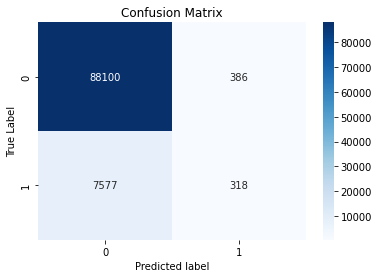

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     88486
         1.0       0.45      0.04      0.07      7895

    accuracy                           0.92     96381
   macro avg       0.69      0.52      0.52     96381
weighted avg       0.88      0.92      0.88     96381

ROC AUC Score: 0.52


In [4]:
# Création d'un modèle XGBoost avec hyperparamètres standards
model = XGBClassifier()
# Entrainement du modèle
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Pour la classe 1 (crédit refusé), le recall est très mauvais. Recall = 318/(318+7577) = 0.04. C'est dû au déséquilibre entre les classes.

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

### Recall & AUC sur données rééquilibrées

Il faut augmenter le poids de la classe positive pour améliorer la performance du modèle. Le XGBoost permet de gérer les classes inégales avec le paramètre scale_pos_weight.

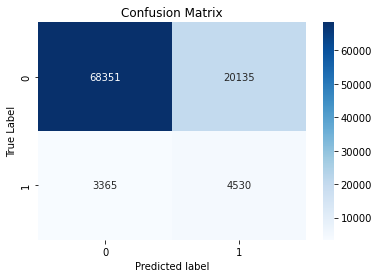

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     88486
         1.0       0.18      0.57      0.28      7895

    accuracy                           0.76     96381
   macro avg       0.57      0.67      0.57     96381
weighted avg       0.89      0.76      0.81     96381

ROC AUC Score: 0.67


In [5]:
# rééquilibrage des classes
model = XGBClassifier(scale_pos_weight=11)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

L'équilibrage des classes permet d'améliorer nettement le recall de la classe 1, ainsi que le score ROC AUC.

On peut donc utiliser le paramètre feature_importance du modèle

### Equilibrage des classes avec la librairie imblearn

Essayons maintennt d'améliorer la performance du modèle en réalisant un équilibrage des classes avec imblearn (problème traité plus en détail dans la phase 2 du projet)

In [6]:
# Imputation des données manquantes et xgboost
# Création d'un pipeline imblearn (et non sckikit-learn)
steps = [('oversample', RandomUnderSampler(random_state=42)),
         ('impute', SimpleImputer(strategy='median')),
         ('model', XGBClassifier())]

pipeline = Pipeline(steps=steps)

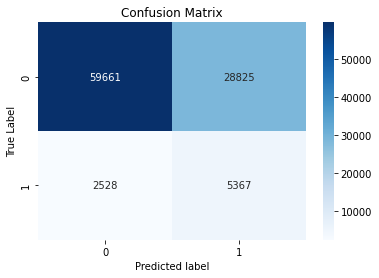

              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     88486
         1.0       0.16      0.68      0.26      7895

    accuracy                           0.67     96381
   macro avg       0.56      0.68      0.52     96381
weighted avg       0.89      0.67      0.75     96381

ROC AUC Score: 0.68
CPU times: user 58.2 s, sys: 292 ms, total: 58.5 s
Wall time: 4.66 s


In [7]:
%%time
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Nette amélioration du recall qui est désormais égal pour les classes 0 et 1.

### Tri des features du modèle XGBoost retenu

https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order

Le modèle retenu est le dernier entraîné avec un pipeline imblearn.

In [8]:
# Tri de l'importance des features par ordre décroissant
thresholds = -np.sort(-pipeline['model'].feature_importances_)

https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

In [9]:
# recherche des noms de features dans le X_train
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, pipeline['model'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

In [10]:
# création d'un dataframe stockant l'importance des features par ordre décroissant
main_features = pd.DataFrame.from_dict(feats, orient='index').sort_values(by=0, ascending=False)
main_features = main_features.rename(columns={0:"feature_importance"})
# Affichage des 10 features les plus importantes
main_features.head(10)

,feature_importance
EXT_SOURCE_3,0.043696
EXT_SOURCE_2,0.034378
CODE_GENDER,0.027603
NAME_EDUCATION_TYPE_Higher_education,0.024350
NAME_CONTRACT_TYPE_Cash_loans,0.017443
NAME_INCOME_TYPE_State_servant,0.015136
PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,0.014797
FLAG_OWN_CAR,0.014019
POS_SK_DPD_DEF_MAX,0.012409
INSTAL_PAYMENT_DIFF_MEAN,0.011773


Text(0.5, 1.0, 'Xgboost Feature Importance by descending order (first 20 features)')

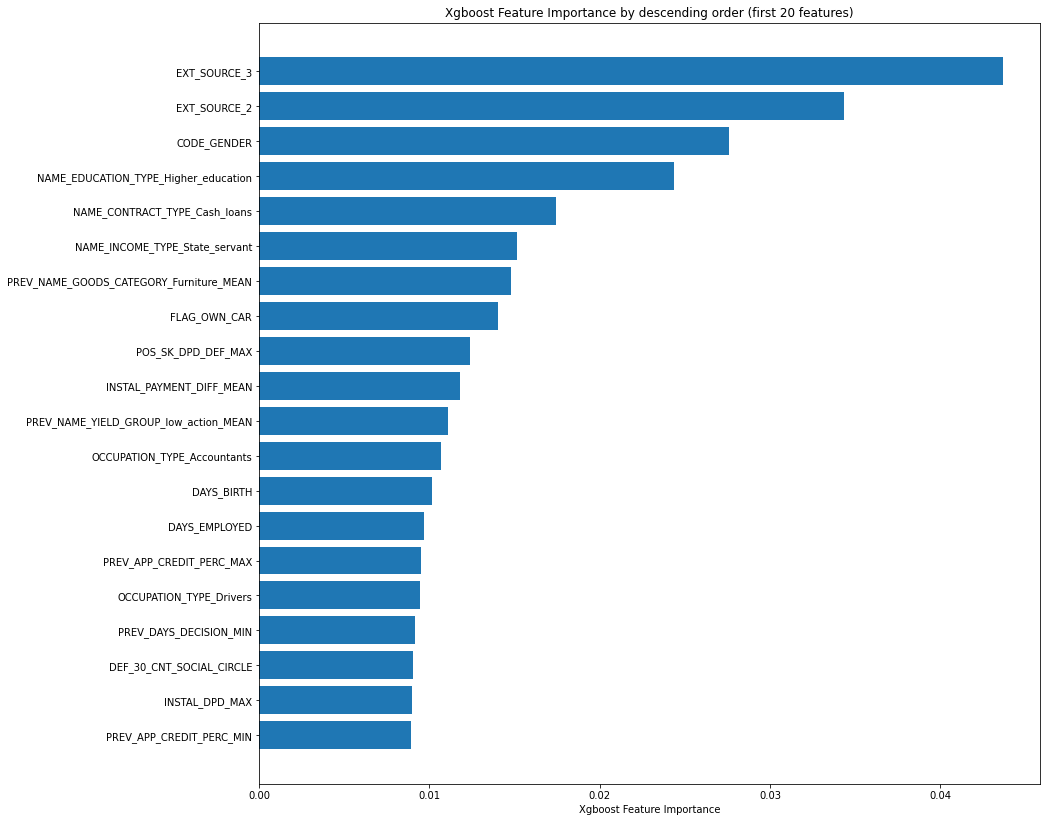

In [11]:
# Graphique des 20 principales variables
plt.rcParams["figure.figsize"] = (14, 14)
sorted_idx = main_features.values.flatten().argsort()
sorted_idx = sorted_idx[-20:]
plt.barh(main_features.index[sorted_idx],
         main_features.values.flatten()[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Xgboost Feature Importance by descending order (first 20 features)")

On peut tester la performance du modèle en fonction du nombre de features. On commence les tests en choissant les features par ordre décroissant d'importance. Le processus utilisant la fonction scikit-learn 'SelectFromModel' est décrit dans cet article:

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Des tests de cette fonction ont été effectués ci-dessous mais ils ne sont pas très utiles car l'importance des variables dépend du modèle choisi et des paramètres sélectionés. 

In [12]:
# select list of thresholds to use
thresholds2 = thresholds[1:3]
# Store results in a dataframe
column_names = ["threshold", "n", "recall"]
df_recall=pd.DataFrame(columns=column_names)

for thresh in thresholds2:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    # Reduce number of columns in X_train
    # keep column only if feature importance is above threshold
    select_X_train = selection.transform(X_train.values)
    # train new model using reduced features number
    selection_model = XGBClassifier(scale_pos_weight=11)
    selection_model.fit(select_X_train, y_train)
    # eval model
    # Use same columns than in select_X_train
    select_X_test = selection.transform(X_test.values)
    # predict y_test with model
    y_pred = selection_model.predict(select_X_test)
    # Calculate recall score (metric we want to maximise)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    # Add new row to dataframe
    new_row = [thresh, select_X_train.shape[1], recall*100.0]
    new_line = pd.DataFrame([new_row], columns=column_names)
    df_recall = pd.concat([df_recall, new_line])
    # print new results
    print("Thresh=%.3f, n=%d, recall: %.2f%%, roc_auc: %.2f%%" % (thresh,
                                                                    select_X_train.shape[1],
                                                                    recall*100,
                                                                    auc_roc*100))

Thresh=0.034, n=1, recall: 66.57%, roc_auc: 61.44%
Thresh=0.028, n=3, recall: 62.39%, roc_auc: 64.84%


https://towardsdatascience.com/precision-vs-recall-evaluating-model-performance-in-credit-card-fraud-detection-bb24958b2723

https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees

## Influence globale des variables avec Shapley

Afin d'affiner l'importanced de chaque variable au sein du modèle, on peut compléter l'analyse en étudiant les valeurs de Shapley. Voir notebook "9_interpretability" pour plus de précisions.

In [13]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [14]:
# Chargement des 50 features les plus importantes selon la modèle XGBoost retenu
X_top50 = X[main_features.head(50).index]

En choisissant 50 variables, nous avons une vision assez large des relations entre variables et target.

### Calcul des valeurs de Shapley

In [15]:
# 1- Echantillonnage des données avec RandomUnderSampler (voir phase_2 pour plus d'explications)
rus = RandomUnderSampler(random_state=42, replacement=True)
# rebalancement des classes
x_rus, y_rus = rus.fit_resample(X_top50, y)
print('original dataset shape:', Counter(y.TARGET))
print('Resample dataset shape', Counter(y_rus.TARGET))

original dataset shape: Counter({0.0: 268139, 1.0: 23923})
Resample dataset shape Counter({0.0: 23923, 1.0: 23923})


In [16]:
del X_top50
gc.collect()

14747

In [17]:
# Création d'un train & test set à partir des données sous-échantillonnées
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(x_rus, y_rus,
                                                                    test_size=0.3,
                                                                    random_state=2)

In [18]:
del x_rus
del y_rus
gc.collect()

0

In [19]:
X_rus_train.head()

,EXT_SOURCE_3,EXT_SOURCE_2,CODE_GENDER,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_State_servant,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,FLAG_OWN_CAR,POS_SK_DPD_DEF_MAX,INSTAL_PAYMENT_DIFF_MEAN,...,BURO_DAYS_CREDIT_ENDDATE_MAX,DAYS_LAST_PHONE_CHANGE,NAME_HOUSING_TYPE_House_/_apartment,ORGANIZATION_TYPE_Trade:_type_7,PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,ORGANIZATION_TYPE_Government,WEEKDAY_APPR_PROCESS_START_THURSDAY,DAYS_ID_PUBLISH,NAME_FAMILY_STATUS_Separated
26449,0.105473,0.063543,1.0,0.0,1.0,0.0,0.000,0.0,0.0,0.000000,...,132.0,-249.0,1.0,0.0,1.000000,0.0,0.0,0.0,-699.0,0.0
28590,0.472253,0.212280,0.0,0.0,1.0,0.0,0.000,1.0,15.0,5515.486875,...,941.0,-859.0,1.0,0.0,0.333333,0.0,0.0,1.0,-3111.0,0.0
16542,0.547810,0.464989,1.0,0.0,1.0,0.0,0.000,0.0,2.0,0.000000,...,1029.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,-398.0,0.0
994,0.684828,0.284672,0.0,1.0,1.0,0.0,0.000,1.0,0.0,0.000000,...,1520.0,-617.0,1.0,0.0,0.000000,0.0,0.0,0.0,-2557.0,0.0
31557,NaN,0.587407,0.0,0.0,1.0,0.0,0.625,0.0,0.0,0.000000,...,-294.0,0.0,1.0,0.0,0.250000,0.0,0.0,0.0,-4787.0,0.0


In [20]:
# Création d'un pipeline scikit-learn
# Ne pas utiliser un pipeline imblearn, incompatible avec shap
steps = [('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
         ('scaler', StandardScaler()),
        ('model', XGBClassifier())]

In [21]:
pipe50 = skpipe(steps=steps)

In [22]:
pipe50.fit(X_rus_train, y_rus_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [23]:
# On issole la partie modèle
pipe50["model"]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
# Etapes 1 & 2 du pipe avant modélisation
pipe50[:-1]

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [25]:
# Calcul des valeurs de Shapley
explainer = shap.TreeExplainer(pipe50["model"], pipe50[:-1].fit_transform(X_rus_train))
shap_values = explainer.shap_values(pipe50[:-1].transform(X_rus_test))

100%|===================| 14344/14354 [00:23<00:00]        

### Graphe d'importance des features en fonction des valeurs de Shapley

L'objectif est maintenant d'analyser la liste des features importantes telles que déterminées par le modèle XGBoost ainsi que par les valeurs de Shapley.

In [26]:
class_names=['crédit accepté','crédit refusé']

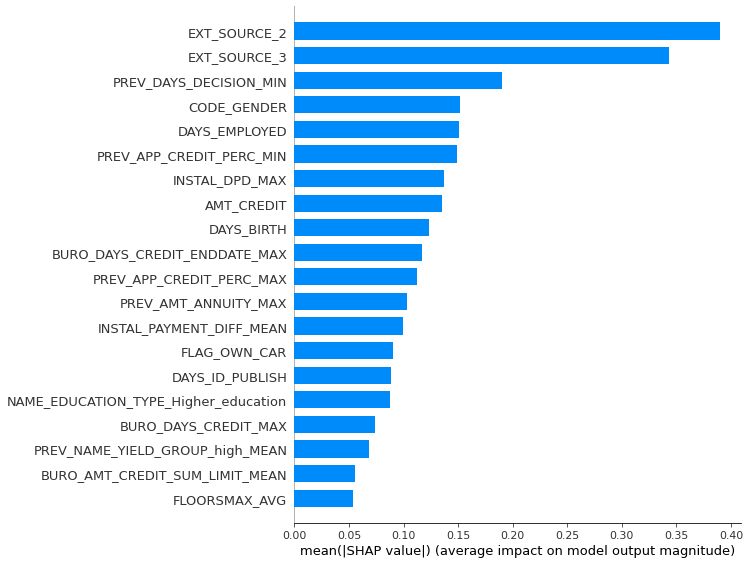

In [27]:
shap.summary_plot(shap_values, X_rus_test, plot_type="bar", class_names=class_names)

## Compréhension et analyse des features principales

Nous réalisons maintenant une analyse métier des features afin de sélectionner les variables ayant le plus de sens dans ce cadre.

### PREV_DAYS_DECISION_MIN

In [28]:
X_train["PREV_DAYS_DECISION_MIN"].head()

215169   -1229.0
275171   -2688.0
139526   -1632.0
283387   -2500.0
14341    -2608.0
Name: PREV_DAYS_DECISION_MIN, dtype: float64

In [29]:
# Relative to current application when was the decision about previous application made
# => Nombre de jours séparant la prise de décision actuelle de celle du précédent crédit
# https://jovian.ai/archanjd5/eda-final-part-2

# transformation des valeurs en nombres positifs
X_train["PREV_DAYS_DECISION_MIN"]=X_train["PREV_DAYS_DECISION_MIN"].abs()

In [30]:
X_train["PREV_DAYS_DECISION_MIN"].isnull().sum()

685

In [31]:
X_train["PREV_DAYS_DECISION_MIN"].head()

215169    1229.0
275171    2688.0
139526    1632.0
283387    2500.0
14341     2608.0
Name: PREV_DAYS_DECISION_MIN, dtype: float64

In [32]:
X_train["PREV_DAYS_DECISION_MIN"].isnull().sum()

685

Valeurs manquantes = pas de crédit précédent ou non renseigné. Imputation standard.

### AMT_CREDIT

AMT_CREDIT: Final credit amount on the previous application.  
montant du crédit précédent perçu  

In [33]:
X_train["AMT_CREDIT"].head()

215169     508495.5
275171     728460.0
139526     239850.0
283387     450000.0
14341     1350000.0
Name: AMT_CREDIT, dtype: float64

PREV_APP_CREDIT_PERC_MIN = AMT_APPLICATION/AMT_CREDIT: ratio entre montant initialement demandé et montant final du dernier crédit. On prend le ratio le plus faible si plusieurs crédits contractés dans le passé.

In [34]:
X_train["PREV_APP_CREDIT_PERC_MIN"].head()

215169    0.627786
275171    0.906651
139526    0.938086
283387    0.000000
14341     0.000000
Name: PREV_APP_CREDIT_PERC_MIN, dtype: float64

In [35]:
X_train["PREV_APP_CREDIT_PERC_MIN"].isnull().sum()

839

Si NaN => pas de précédent crédit. Dans ce cas, imputation standard.

### EXT_SOURCE_2 & EXT_SOURCE_3

In [36]:
X_train["EXT_SOURCE_2"].head()

215169    0.092250
275171    0.779680
139526    0.475448
283387    0.698863
14341     0.658295
Name: EXT_SOURCE_2, dtype: float64

In [37]:
X_train["EXT_SOURCE_2"].isnull().sum()

398

In [38]:
X_train["EXT_SOURCE_3"].head()

215169    0.574447
275171         NaN
139526    0.159520
283387    0.456110
14341     0.761026
Name: EXT_SOURCE_3, dtype: float64

In [39]:
X_train["EXT_SOURCE_3"].isnull().sum()

38235

Ces variables ont des distributions différentes en fonction de la target. On imputera les valeurs manquantes par classe.

In [40]:
# Analyse de la corrélation entre EXT_SOURCE_2 et EXT_SOURCE_3
X_train["EXT_SOURCE_2"].corr(X_train["EXT_SOURCE_3"])

0.10636151592095928

Ces 2 variables ne sont pas corrélées.

### INSTAL_DPD_MAX

In [41]:
# Plus gros retard de paiements observé sur les précédents crédits
X_train["INSTAL_DPD_MAX"].head()

215169     0.0
275171     0.0
139526     0.0
283387    22.0
14341     27.0
Name: INSTAL_DPD_MAX, dtype: float64

In [42]:
# nombre de clients sans retards de paiement
len(X_train["INSTAL_DPD_MAX"][X_train["INSTAL_DPD_MAX"]==0])

91247

In [43]:
# nombre de features non renseignées
X_train["INSTAL_DPD_MAX"].isnull().sum()

633

Imputation standard

### DAYS_BIRTH

In [44]:
# Age du client en nombre de jours au moment de la signature du crédit
X_train['DAYS_BIRTH'].head()

215169   -20255.0
275171   -21989.0
139526   -25054.0
283387   -18862.0
14341    -21817.0
Name: DAYS_BIRTH, dtype: float64

In [45]:
# changement de signe
X_train['DAYS_BIRTH'] = X_train['DAYS_BIRTH'].abs()

In [46]:
# Age du client en nombre de jours au moment de la signature du crédit
X_train['DAYS_BIRTH'].head()

215169    20255.0
275171    21989.0
139526    25054.0
283387    18862.0
14341     21817.0
Name: DAYS_BIRTH, dtype: float64

In [47]:
X_train['DAYS_BIRTH'].isnull().sum()

0

### DAYS_EMPLOYED

In [48]:
# nombre de jours d'ancienneté pour les salariés
X_train['DAYS_EMPLOYED'].head()

215169    -335.0
275171   -5862.0
139526       NaN
283387   -7093.0
14341        NaN
Name: DAYS_EMPLOYED, dtype: float64

In [49]:
# changement de signe
X_train['DAYS_EMPLOYED'] = X_train['DAYS_EMPLOYED'].abs()

In [50]:
X_train['DAYS_EMPLOYED'].head()

215169     335.0
275171    5862.0
139526       NaN
283387    7093.0
14341        NaN
Name: DAYS_EMPLOYED, dtype: float64

In [51]:
X_train['DAYS_EMPLOYED'][X_train['DAYS_EMPLOYED']==0]

23691     0.0
121625    0.0
Name: DAYS_EMPLOYED, dtype: float64

In [52]:
X_train['DAYS_EMPLOYED'].isnull().sum()

35428

imputation standard

### FLAG_OWN_CAR

In [53]:
# nombre de jours d'ancienneté pour les salariés
X_train['FLAG_OWN_CAR'].head()

215169    0.0
275171    0.0
139526    0.0
283387    0.0
14341     1.0
Name: FLAG_OWN_CAR, dtype: float64

In [54]:
X_train['FLAG_OWN_CAR'].isnull().sum()

0

### NAME_EDUCATION_TYPE_Higher_education

In [55]:
X_train['NAME_EDUCATION_TYPE_Higher_education'].isnull().sum()

0

### NAME_INCOME_TYPE_State_servant

In [56]:
X_train['NAME_INCOME_TYPE_State_servant'].isnull().sum()

0

## Features sélectionnées

In [57]:
features_select = ['EXT_SOURCE_3','EXT_SOURCE_2', 'PREV_DAYS_DECISION_MIN', 'CODE_GENDER','DAYS_EMPLOYED', 
                     'PREV_APP_CREDIT_PERC_MIN', 'INSTAL_DPD_MAX','AMT_CREDIT', 'DAYS_BIRTH',
                     'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE_Higher_education', 'NAME_INCOME_TYPE_State_servant']

In [58]:
X_train[features_select].head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,NAME_INCOME_TYPE_State_servant
215169,0.574447,0.092250,1229.0,1.0,335.0,0.627786,0.0,508495.5,20255.0,0.0,0.0,0.0
275171,NaN,0.779680,2688.0,1.0,5862.0,0.906651,0.0,728460.0,21989.0,0.0,0.0,0.0
139526,0.159520,0.475448,1632.0,1.0,NaN,0.938086,0.0,239850.0,25054.0,0.0,0.0,0.0
283387,0.456110,0.698863,2500.0,0.0,7093.0,0.000000,22.0,450000.0,18862.0,0.0,1.0,1.0
14341,0.761026,0.658295,2608.0,1.0,NaN,0.000000,27.0,1350000.0,21817.0,1.0,0.0,0.0


In [59]:
# Nettoyage de la mémoire
del X_train
del X_test
gc.collect()

5036

In [60]:
X_train_select = X_rus_train[features_select]

In [61]:
X_test_select = X_rus_test[features_select]

In [62]:
X_train_select.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,NAME_INCOME_TYPE_State_servant
26449,0.105473,0.063543,-249.0,1.0,-1686.0,0.909906,0.0,341280.0,-10167.0,0.0,0.0,0.0
28590,0.472253,0.212280,-1775.0,0.0,-3314.0,0.798153,183.0,284400.0,-11598.0,1.0,0.0,0.0
16542,0.547810,0.464989,-2467.0,1.0,-1161.0,1.026477,25.0,700830.0,-15920.0,0.0,0.0,0.0
994,0.684828,0.284672,-617.0,0.0,-6830.0,1.000000,0.0,1042560.0,-14970.0,1.0,1.0,0.0
31557,NaN,0.587407,-1070.0,0.0,-349.0,1.000000,2.0,301500.0,-12114.0,0.0,0.0,0.0


In [63]:
X_test_select.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,NAME_INCOME_TYPE_State_servant
27082,0.209155,0.631050,-379.0,1.0,-2246.0,0.882863,5.0,90000.0,-10013.0,0.0,1.0,0.0
34250,0.798137,0.426848,-1499.0,1.0,-4090.0,0.000000,8.0,427500.0,-11866.0,0.0,1.0,0.0
32557,0.785052,0.335196,-619.0,1.0,-254.0,0.000000,3.0,998838.0,-16486.0,0.0,0.0,0.0
14726,0.520898,0.681291,-2728.0,1.0,NaN,0.878272,0.0,360000.0,-21438.0,0.0,0.0,0.0
15748,0.431192,0.397762,-771.0,1.0,-1735.0,0.878272,0.0,654498.0,-14911.0,1.0,0.0,0.0


In [64]:
negative_cols = ['PREV_DAYS_DECISION_MIN', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
for column in negative_cols:
    X_train_select[column] = X_train_select[column].abs()
    X_test_select[column] = X_test_select[column].abs()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Calcul des valeurs de Shapley sur variables sélectionnées

Il faut commencer par entraîner un nouveau modèe avec les variables sélectionnées

In [65]:
X_train_select.shape

(33492, 12)

In [66]:
X_test_select.shape

(14354, 12)

In [67]:
X_test_select.columns

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_DAYS_DECISION_MIN', 'CODE_GENDER',
       'DAYS_EMPLOYED', 'PREV_APP_CREDIT_PERC_MIN', 'INSTAL_DPD_MAX',
       'AMT_CREDIT', 'DAYS_BIRTH', 'FLAG_OWN_CAR',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_INCOME_TYPE_State_servant'],
      dtype='object')

In [68]:
pipe12 = skpipe(steps=steps)
pipe12.fit(X_train_select, y_rus_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [69]:
# Memory error
explainer = shap.TreeExplainer(pipe12["model"], pipe12[:-1].fit_transform(X_train_select))

In [70]:
shap_values = explainer.shap_values(pipe12[:-1].transform(X_test_select))

 99%|===================| 14225/14354 [00:19<00:00]        

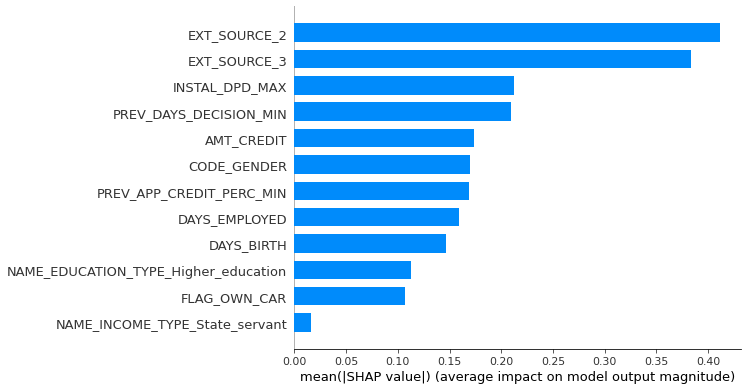

In [71]:
shap.summary_plot(shap_values, X_test_select, plot_type="bar", class_names=class_names)

### Calcul de l'importance des features sélectionnées avec XGBoost

In [72]:
X_train_select.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,NAME_INCOME_TYPE_State_servant
26449,0.105473,0.063543,249.0,1.0,1686.0,0.909906,0.0,341280.0,10167.0,0.0,0.0,0.0
28590,0.472253,0.212280,1775.0,0.0,3314.0,0.798153,183.0,284400.0,11598.0,1.0,0.0,0.0
16542,0.547810,0.464989,2467.0,1.0,1161.0,1.026477,25.0,700830.0,15920.0,0.0,0.0,0.0
994,0.684828,0.284672,617.0,0.0,6830.0,1.000000,0.0,1042560.0,14970.0,1.0,1.0,0.0
31557,NaN,0.587407,1070.0,0.0,349.0,1.000000,2.0,301500.0,12114.0,0.0,0.0,0.0


In [73]:
X_test_select.shape

(14354, 12)

In [74]:
y_rus_test.shape

(14354, 1)

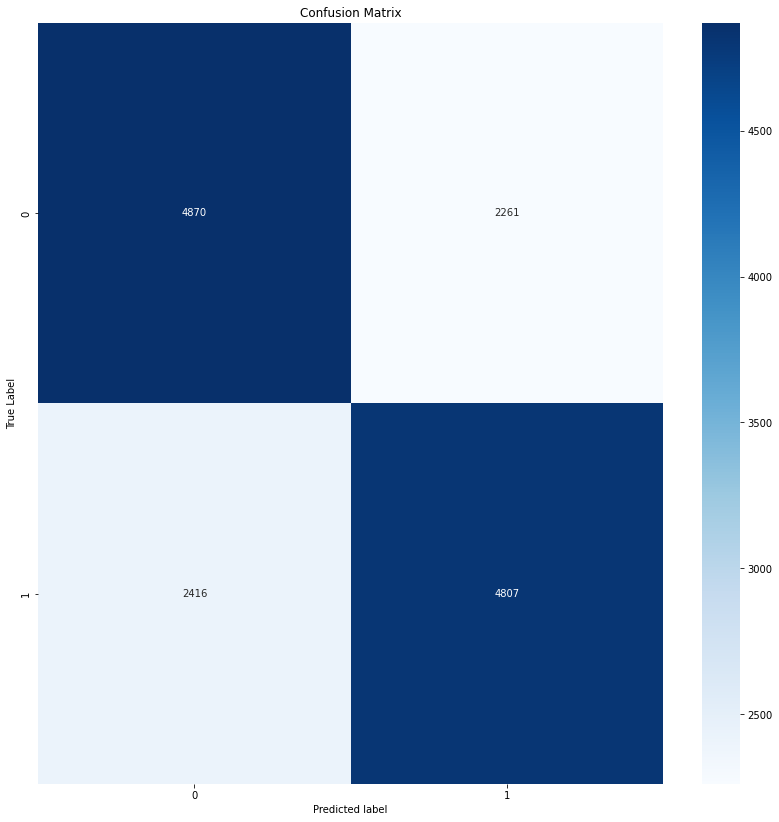

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      7131
         1.0       0.68      0.67      0.67      7223

    accuracy                           0.67     14354
   macro avg       0.67      0.67      0.67     14354
weighted avg       0.67      0.67      0.67     14354

ROC AUC Score: 0.67


In [75]:
# make predictions for test data and evaluate
y_pred = pipe12.predict(X_test_select)

# Plot the confusion matrix
plot_confusion_matrix(y_rus_test, y_pred)

On obtient le même niveau de recall avec les 11 features sélectionnées qu'avec l'ensemble des features. 

In [76]:
# recherche des noms de features dans le X_train
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_select.columns, pipe12['model'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

In [77]:
# création d'un dataframe stockant l'importance des features
main_features = pd.DataFrame.from_dict(feats, orient='index').sort_values(by=0, ascending=False)
main_features = main_features.rename(columns={0:"feature_importance"})
main_features.head(50)

,feature_importance
EXT_SOURCE_3,0.159938
NAME_EDUCATION_TYPE_Higher_education,0.150029
EXT_SOURCE_2,0.122427
CODE_GENDER,0.107314
FLAG_OWN_CAR,0.073349
INSTAL_DPD_MAX,0.060942
DAYS_EMPLOYED,0.058607
PREV_DAYS_DECISION_MIN,0.055112
NAME_INCOME_TYPE_State_servant,0.055076
PREV_APP_CREDIT_PERC_MIN,0.054792


Text(0.5, 1.0, 'Xgboost Feature Importance by descending order (first 50 features)')

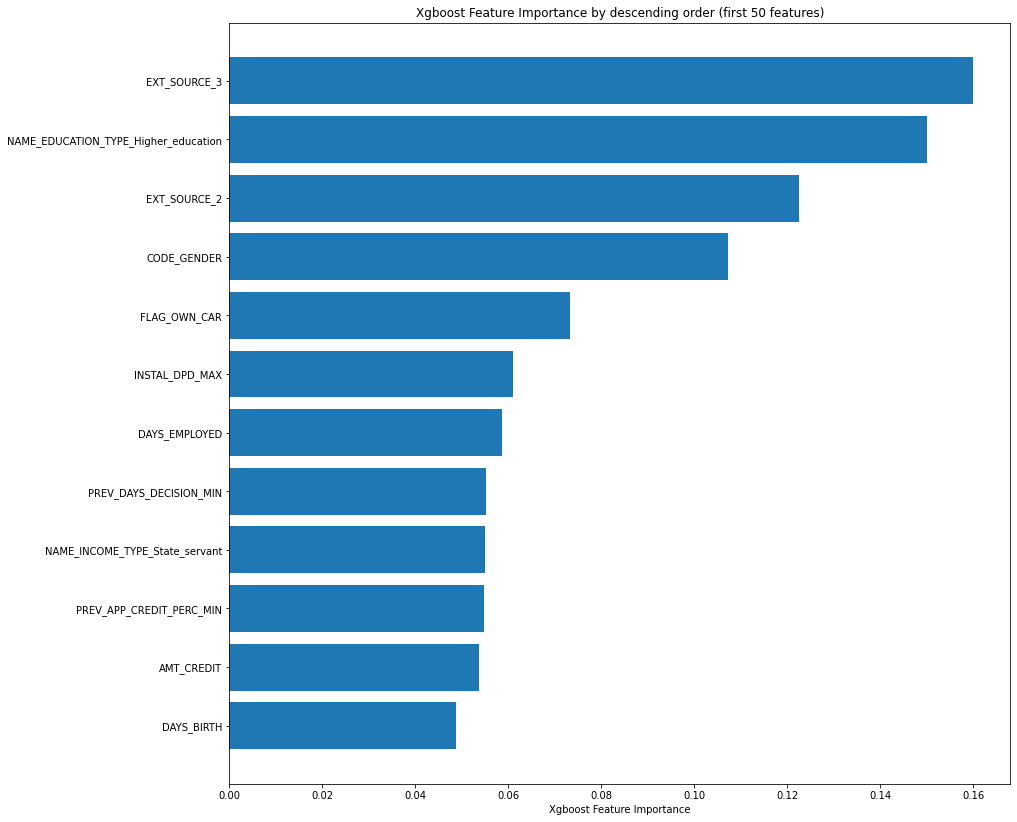

In [78]:
# Grape 
plt.rcParams["figure.figsize"] = (14, 14)
sorted_idx = main_features.values.flatten().argsort()
plt.barh(main_features.index[sorted_idx],
         main_features.values.flatten()[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Xgboost Feature Importance by descending order (first 50 features)")

## Sélection finale des features

Compte tenu de la faible valeur de Shapley de la variable 'NAME_INCOME_TYPE_State_servant', on la supprime.

In [79]:
X_train_select = X_train_select.drop(columns=['NAME_INCOME_TYPE_State_servant'])

In [80]:
X_test_select = X_test_select.drop(columns=['NAME_INCOME_TYPE_State_servant'])

In [81]:
X_train_select.shape

(33492, 11)

In [82]:
X_train_select.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education
26449,0.105473,0.063543,249.0,1.0,1686.0,0.909906,0.0,341280.0,10167.0,0.0,0.0
28590,0.472253,0.212280,1775.0,0.0,3314.0,0.798153,183.0,284400.0,11598.0,1.0,0.0
16542,0.547810,0.464989,2467.0,1.0,1161.0,1.026477,25.0,700830.0,15920.0,0.0,0.0
994,0.684828,0.284672,617.0,0.0,6830.0,1.000000,0.0,1042560.0,14970.0,1.0,1.0
31557,NaN,0.587407,1070.0,0.0,349.0,1.000000,2.0,301500.0,12114.0,0.0,0.0


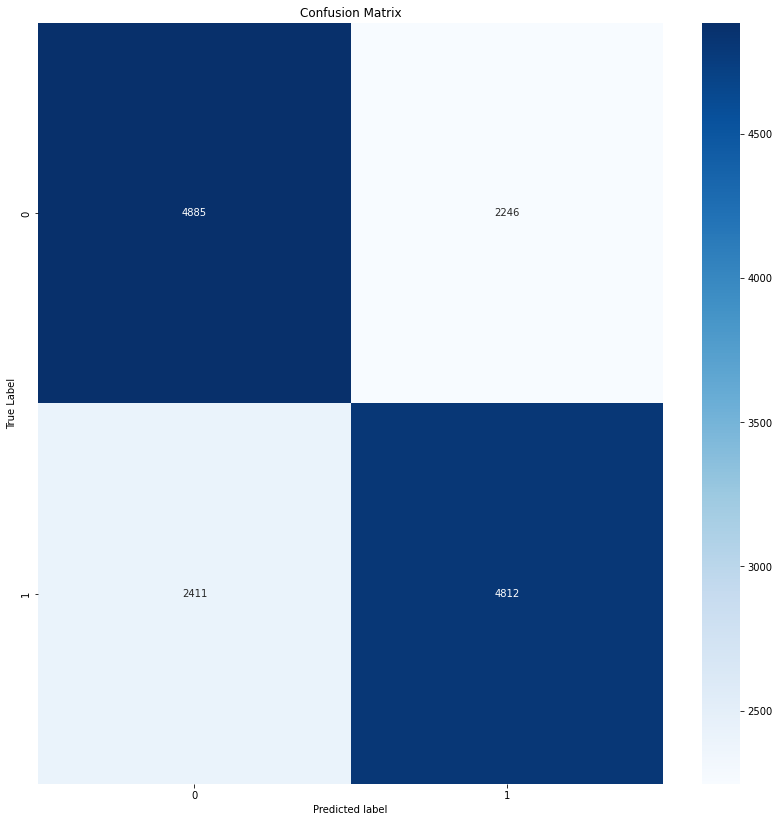

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      7131
         1.0       0.68      0.67      0.67      7223

    accuracy                           0.68     14354
   macro avg       0.68      0.68      0.68     14354
weighted avg       0.68      0.68      0.68     14354

ROC AUC Score: 0.68


In [83]:
# Entrainement d'un nouveau modèle XGBoost avec les variables finales
pipe11 = skpipe(steps=steps)
pipe11.fit(X_train_select, y_rus_train)
# make predictions for test data and evaluate
y_pred = pipe11.predict(X_test_select)

# Plot the confusion matrix
plot_confusion_matrix(y_rus_test, y_pred)

### Sauvegarde des données retraitées avec undersampling (utilisées pour Shapley)

In [84]:
# réintégration de la target dans matrice des features pour sauvegarde
X_train_select['TARGET'] = y_rus_train
X_test_select['TARGET'] = y_rus_test

In [85]:
X_train_select.to_csv('../data_models/X_train_final.csv')

In [86]:
X_test_select.to_csv('../data_models/X_test_final.csv')

### Sauvegarde des données brutes avant égalisation des classes

On aura besoin de ces données brutes pour entrainer les modèles dans la phase 2 et choisir les meilleures méthodes pour égaliser les classes.

In [87]:
final_features = X_train_select.columns.to_list()

In [88]:
final_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'PREV_DAYS_DECISION_MIN',
 'CODE_GENDER',
 'DAYS_EMPLOYED',
 'PREV_APP_CREDIT_PERC_MIN',
 'INSTAL_DPD_MAX',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE_Higher_education',
 'TARGET']

In [89]:
len(final_features)

12

In [90]:
final_features.remove('TARGET')

In [91]:
# sélection des 11 features sélections
X_top11 = X[final_features]

In [92]:
# ajout de la target à la matrice X
X_top11['TARGET'] = y


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
X_top11.shape

(292062, 12)

In [94]:
X_top11.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
215169,0.574447,0.092250,-1229.0,1.0,-335.0,0.627786,0.0,508495.5,-20255.0,0.0,0.0,0.0
275171,NaN,0.779680,-2688.0,1.0,-5862.0,0.906651,0.0,728460.0,-21989.0,0.0,0.0,0.0
139526,0.159520,0.475448,-1632.0,1.0,NaN,0.938086,0.0,239850.0,-25054.0,0.0,0.0,0.0
283387,0.456110,0.698863,-2500.0,0.0,-7093.0,0.000000,22.0,450000.0,-18862.0,0.0,1.0,0.0
14341,0.761026,0.658295,-2608.0,1.0,NaN,0.000000,27.0,1350000.0,-21817.0,1.0,0.0,0.0


In [95]:
negative_cols = ['PREV_DAYS_DECISION_MIN', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
for column in negative_cols:
    X_top11[column] = X_top11[column].abs()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
X_top11.to_csv("../data_models/X_top10.csv")